# Classification using ML (over-sampling method)

Dataset: http://www.timeseriesclassification.com/description.php?Dataset=Earthquakes

We adopt the ML methods to classifiy the time series of earthquake and non-earthquake signals.

We have two classes: normal and abnormal. We perform the feature engineering as follows:
<li> We extract the features using the package, tsfel.
<li> We then perform the oversampling for the imbalanced dataset. 
<br>
We demonstrate the three different ML appraoches for binary classification:
<li> RandomForest Classifier
<li> XGBoost Classifier
<li> LightGBM Classifier
<br>
We compare the performance among them.

In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np
from time import time
import tsfel
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, jaccard_score 
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
from sklearn.svm import OneClassSVM
import xgboost as xgb
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = arff.loadarff('Earthquakes_TRAIN.arff')
test = arff.loadarff('Earthquakes_TEST.arff')

In [3]:
train = pd.DataFrame(train[0])
test = pd.DataFrame(test[0])

We have two classes: 0 (negative) and 1 (positive).

In [4]:
train.target.value_counts()

b'0'    264
b'1'     58
Name: target, dtype: int64

The sample is imbalanced.

Plot of the two time-series from the negative and positive classes

<AxesSubplot:>

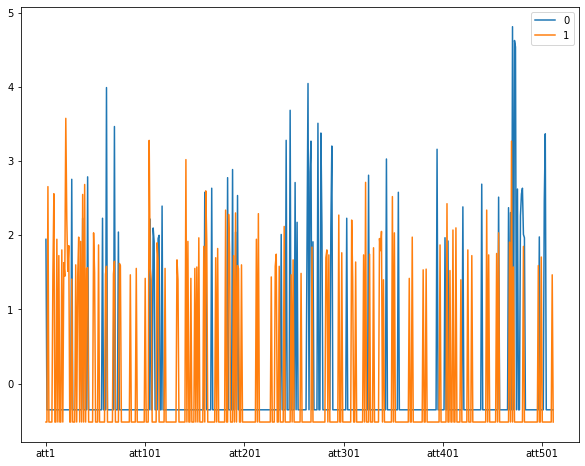

In [5]:
temp = pd.concat([train[train.target==b'0'].iloc[0,:-1], train[train.target==b'1'].iloc[0,:-1]], axis=1)
temp.columns = ['0', '1']
temp.plot(figsize=(10,8))

# Feature extraction using tsfel

In [6]:
# Parameters
fs = 100

window = None

verbose = 0

In [7]:
cfg_file = tsfel.get_features_by_domain() 

In [8]:
train[train.target==b'0'].iloc[0,:-1]
negative = tsfel.time_series_features_extractor(cfg_file, train[train.target==b'0'].iloc[0,:-1], fs=fs, window_size=window, verbose=verbose)
train[train.target==b'1'].iloc[0,:-1]
positive = tsfel.time_series_features_extractor(cfg_file, train[train.target==b'1'].iloc[0,:-1], fs=fs, window_size=window, verbose=verbose)

It generates 390 features without inputing window size.

In [9]:
temp = pd.concat([negative.T,positive.T],axis=1)
temp.columns = ['Negative', 'Positive']
temp.head()

,Negative,Positive
0_FFT mean coefficient_0,0.001147,0.002672
0_FFT mean coefficient_1,0.000532,0.026891
0_FFT mean coefficient_2,0.101582,0.001724
0_FFT mean coefficient_3,0.052324,0.036291
0_FFT mean coefficient_4,0.012107,0.025604


In [10]:
temp.tail()

,Negative,Positive
0_Signal distance,717.573704,793.144568
0_Slope,0.000495,-0.001016
0_Sum absolute diff,288.330882,429.255974
0_Total energy,100.000000,100.000000
0_Zero crossing rate,93.000000,176.000000


In [11]:
def ts_featureextract(data, cfg_file, fs, window, verbose):
    size = len(data.columns)
    temp = pd.DataFrame()
    for i in range(size):
        extract = tsfel.time_series_features_extractor(cfg_file, data.iloc[:,i], 
                                                       fs=fs, window_size=window, 
                                                       verbose=verbose)
        extract = pd.DataFrame(extract.values.reshape(1,-1))
        temp = pd.concat([temp, extract], axis=0)

    return temp.values

In [12]:
temp = train.iloc[:,:-1].T.reset_index(drop=True)
train_X = ts_featureextract(temp, cfg_file, fs, window, verbose)

In [13]:
temp = test.iloc[:,:-1].T.reset_index(drop=True)
test_X = ts_featureextract(temp, cfg_file, fs, window, verbose)

We label the classes, abnormal and normal as an integer 0 and 1, respectively.

In [14]:
le = LabelEncoder()
train_y =le.fit_transform(train.iloc[:,-1])
test_y =le.fit_transform(test.iloc[:,-1])

# Oversampling using SMOTE

We adopt the oversampling by using the package, SMOTE.

In [15]:
smote = SMOTE(k_neighbors=6)

In [16]:
resampled_X, resampled_y = smote.fit_resample(train_X,train_y)

In [17]:
values, counts = np.unique(resampled_y, return_counts=True)
print("Labels ", dict(zip(values, counts)))

Labels  {0: 264, 1: 264}


The sample after oversampling becomes balanced.

# Random Forest Classifier

In [18]:
#Parameters:
num_iteration = 400

In [19]:
steps = [('scale',StandardScaler()), ('clf',RandomForestClassifier(random_state=21))]
pipeline = Pipeline(steps)

In [20]:
param_dist = {'clf__n_estimators':np.arange(2,100,1),
            'clf__max_depth':np.arange(2,100,1), 
            'clf__min_samples_split':[2,3,4,5]}

In [21]:
clf_cv = RandomizedSearchCV(pipeline, param_dist, n_iter=num_iteration, scoring='f1', random_state=21)

In [22]:
start = time()
clf_cv.fit(resampled_X, resampled_y)
end = time()
print("Training time: ", end - start)

Training time:  304.0633907318115


In [23]:
def classification_metrics(truedata, pred):
    print("Metrics")
    print("=======================")
    tn, fp, fn, tp = confusion_matrix(truedata, pred).ravel()
    print("True positive: ", tp)
    print("True negative: ", tn)
    print("False positive: ", fp)
    print("False negative: ", fn)
    print()
    acc = accuracy_score(truedata, pred)
    f1 = f1_score(truedata, pred)
    jaccard = jaccard_score(truedata, pred)
    sensitivity = tp / (tp + fn)
    specificity = tn / (fp + tn)
    gmean = np.sqrt(sensitivity*specificity)
    print("Accuracy: ", round(acc,3))
    print("F1 score: ", round(f1,3))
    print("Jaccard Score: ", round(jaccard,3))
    print("G-Mean: ", round(gmean,3))
    return [acc, f1, jaccard, gmean]

Performance

In [24]:
pred = clf_cv.predict(test_X)


column = ['Accuracy', 'F1 Score', 'Jaccard Score', 'G-Mean']
metrics = pd.DataFrame(columns=column)

temp = pd.DataFrame(classification_metrics(test_y, pred)).T
temp.columns = column
metrics = pd.concat([metrics, temp], axis=0)

metrics_index = []
metrics_index.append('RandomForest')

Metrics
True positive:  3
True negative:  101
False positive:  3
False negative:  32

Accuracy:  0.748
F1 score:  0.146
Jaccard Score:  0.079
G-Mean:  0.289


# XGBoost Classifier

In [25]:
steps = [('scale',StandardScaler()), ('clf',xgb.XGBClassifier(objective='binary:logistic', 
                                                            verbosity = 0, 
                                                            random_state=21, 
                                                            nthread=4))]
pipeline = Pipeline(steps)

In [26]:
param_dist={'clf__n_estimators':np.arange(2,100,1),
            'clf__max_depth':np.arange(2,100,1),
            'clf__eta':np.arange(0.01,.2,.01),
            'clf__lambda':np.arange(0.1,10,0.1), 
            'clf__alpha':np.arange(0.1,10,0.1)}

In [27]:
clf_cv = RandomizedSearchCV(pipeline, param_dist, n_iter=num_iteration, scoring='f1', random_state=21)

In [28]:
start = time()
clf_cv.fit(resampled_X,resampled_y)
end = time()
print("Training time: ", end - start)

Training time:  1340.444619178772


Performance

In [29]:
pred = clf_cv.predict(test_X)

temp = pd.DataFrame(classification_metrics(test_y, pred)).T
temp.columns = column
metrics = pd.concat([metrics, temp], axis=0)

metrics_index.append('XGBoost')

Metrics
True positive:  7
True negative:  100
False positive:  4
False negative:  28

Accuracy:  0.77
F1 score:  0.304
Jaccard Score:  0.179
G-Mean:  0.439


# LightGBM Classifier

In [30]:
steps = [('scale',StandardScaler()), ('clf',lgb.LGBMClassifier(n_jobs=2, random_state=21))]
pipeline = Pipeline(steps)

In [31]:
param_dist = {'clf__n_estimators':np.arange(2,100,1),'clf__max_depth':np.arange(2,100,1),
            'clf__learning_rate':np.arange(.1,1,.1), 'clf__num_leaves':[5,10,15,20,25,30],
           'clf__reg_alpha':np.arange(0.1,10,0.2), 'clf__reg_lambda':np.arange(0.1,10,0.2)}

In [32]:
clf_cv = RandomizedSearchCV(pipeline, param_dist, n_iter=num_iteration, scoring='f1', random_state=21)

In [33]:
start = time()
clf_cv.fit(resampled_X,resampled_y)
end = time()
print("Training time: ", end - start)

Training time:  183.49146914482117


Performance

In [34]:
pred = clf_cv.predict(test_X)

temp = pd.DataFrame(classification_metrics(test_y, pred)).T
temp.columns = column
metrics = pd.concat([metrics, temp], axis=0)

metrics_index.append('LightGBM')

Metrics
True positive:  7
True negative:  99
False positive:  5
False negative:  28

Accuracy:  0.763
F1 score:  0.298
Jaccard Score:  0.175
G-Mean:  0.436


# Summary

In [35]:
metrics.index = metrics_index
metrics

,Accuracy,F1 Score,Jaccard Score,G-Mean
RandomForest,0.748201,0.146341,0.078947,0.288516
XGBoost,0.769784,0.304348,0.179487,0.438529
LightGBM,0.762590,0.297872,0.175000,0.436331


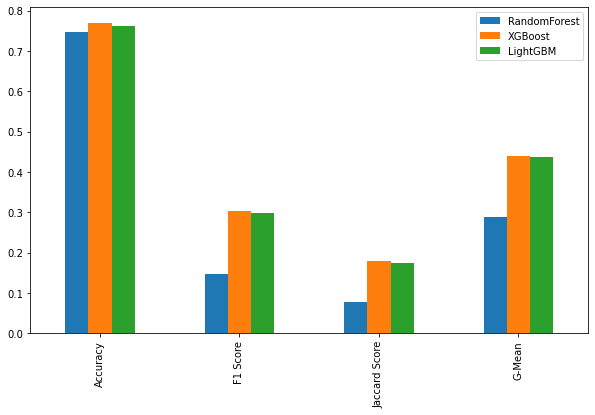

In [36]:
metrics.T.plot(kind='bar', figsize=(10,6))
plt.show()

In this example, XGBoost and LightGBM give the higher F1 score, Jaccard score and G-Mean. LightGBM's training time is much shorter than XGBoost's. 